Number of Adversarial Images: 32
Adversarial Test Accuracy: 0.00%


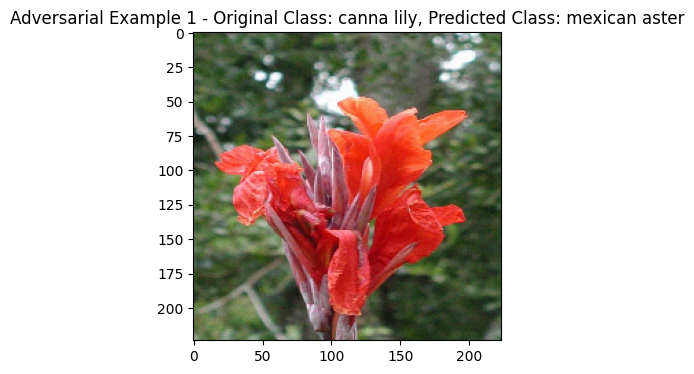

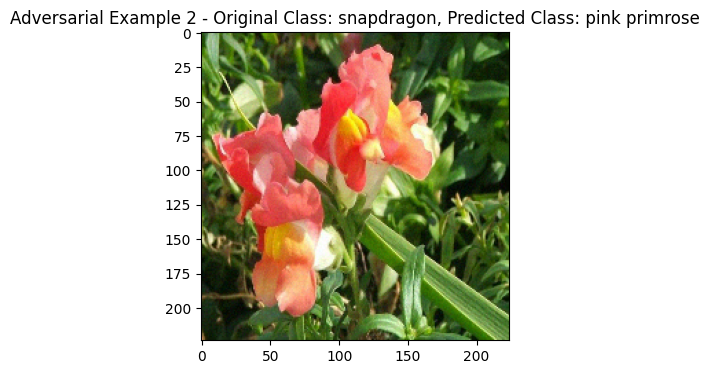

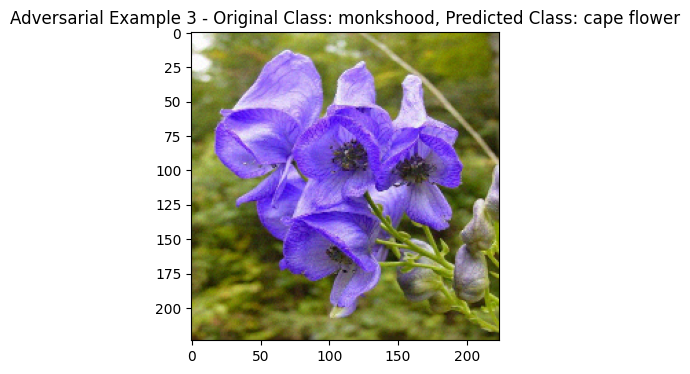

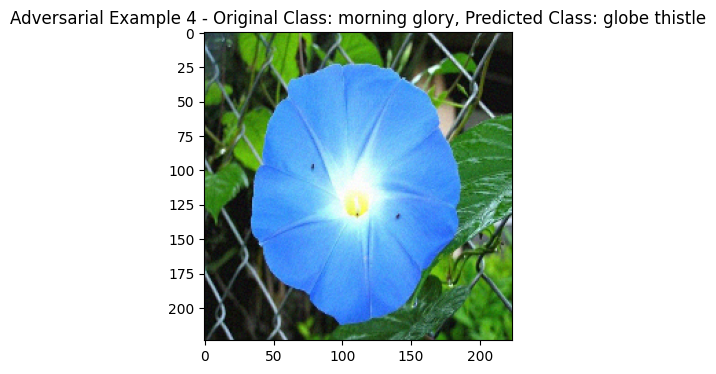

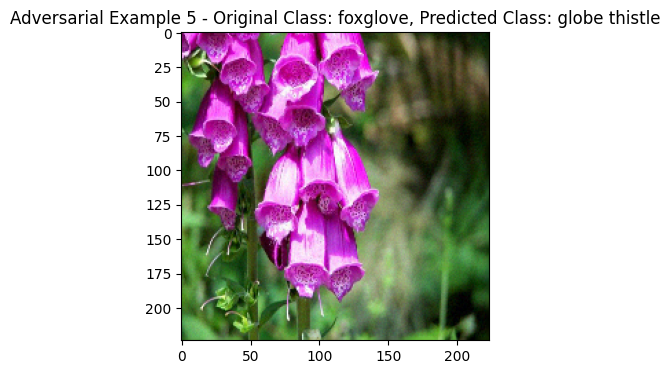

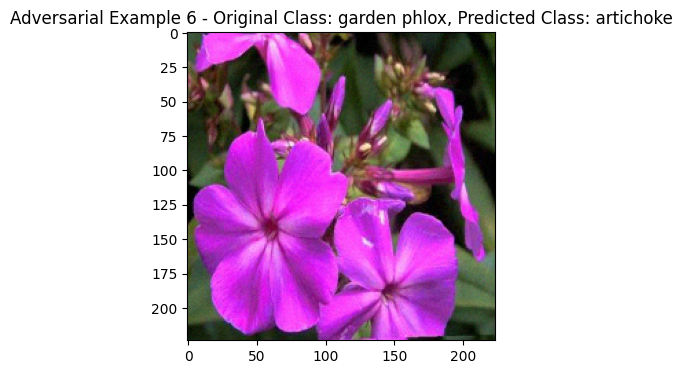

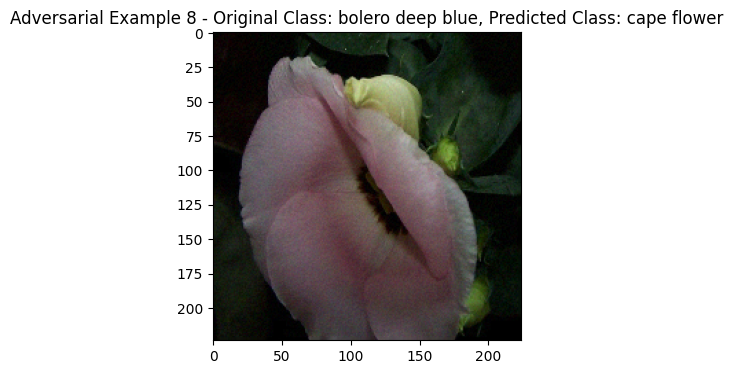

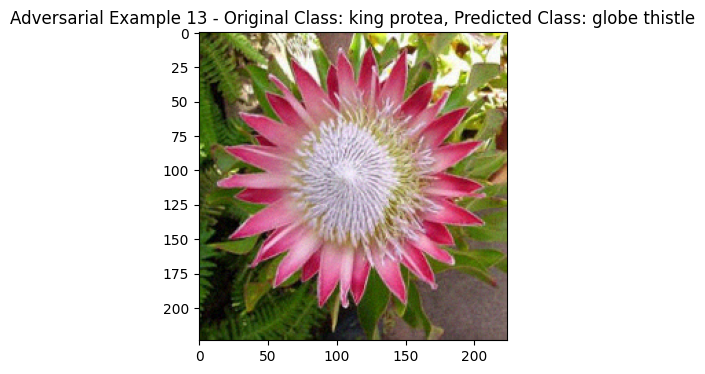

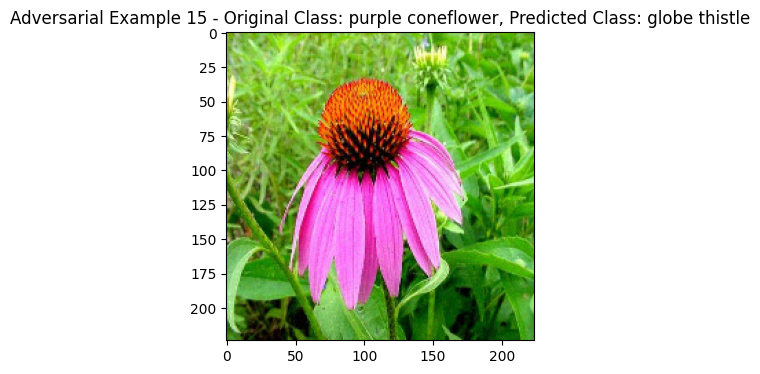

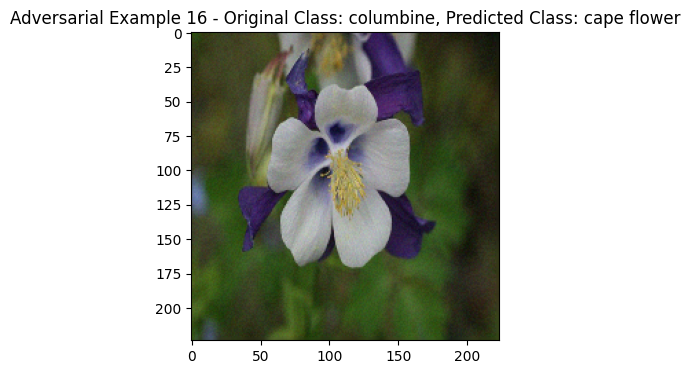

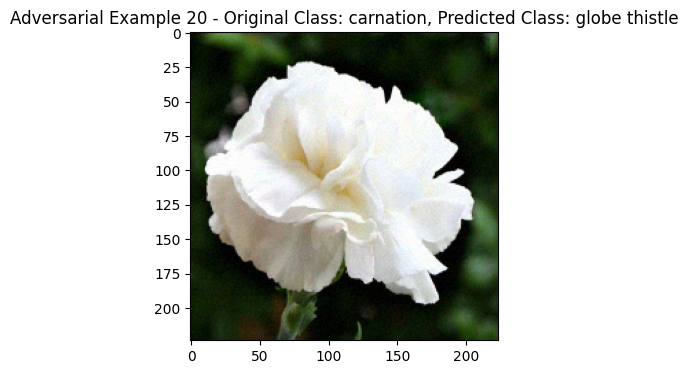

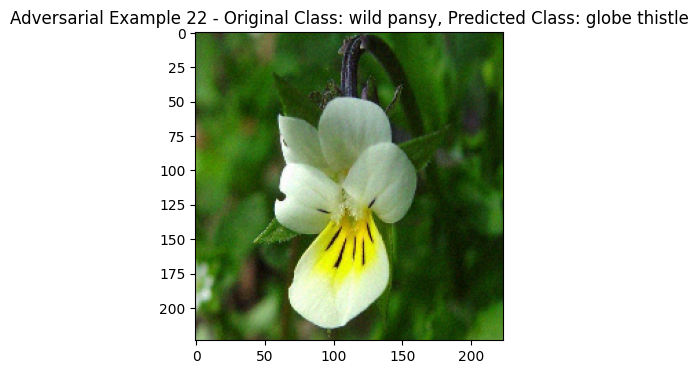

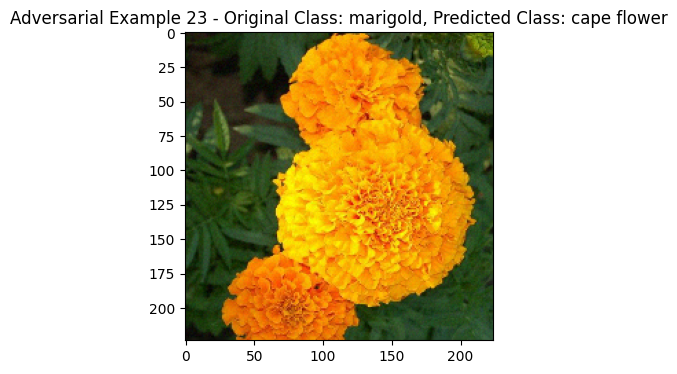

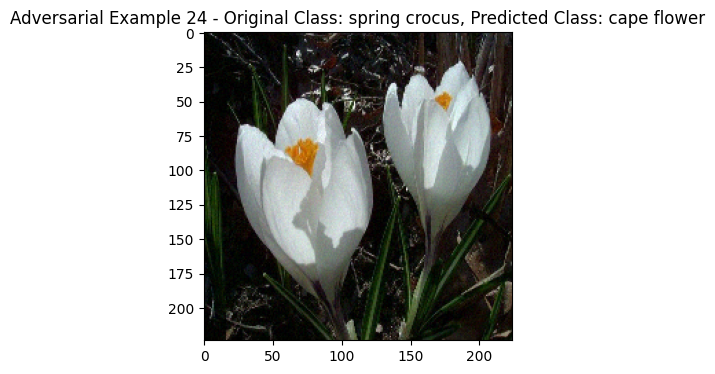

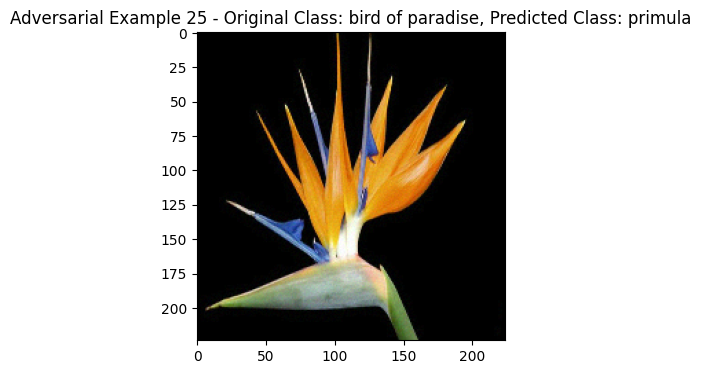

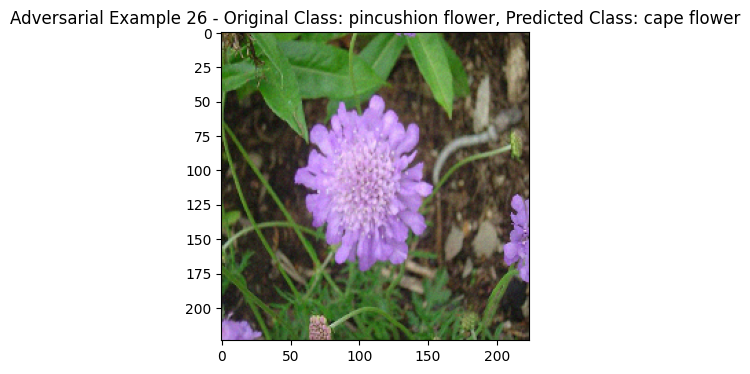

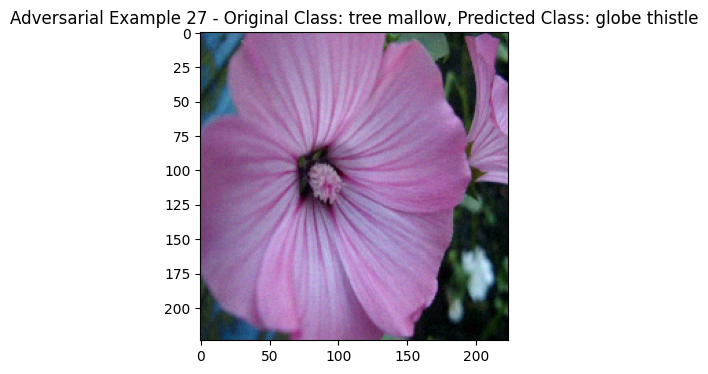

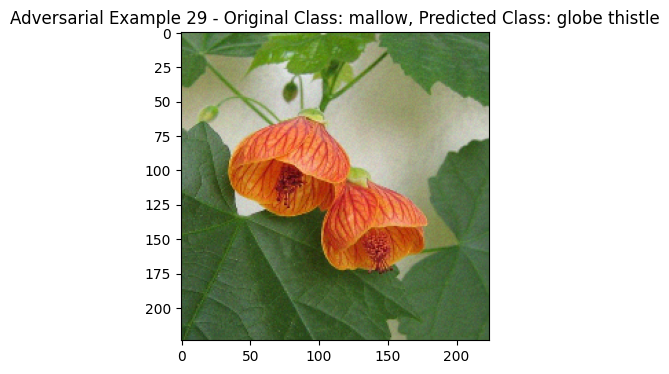

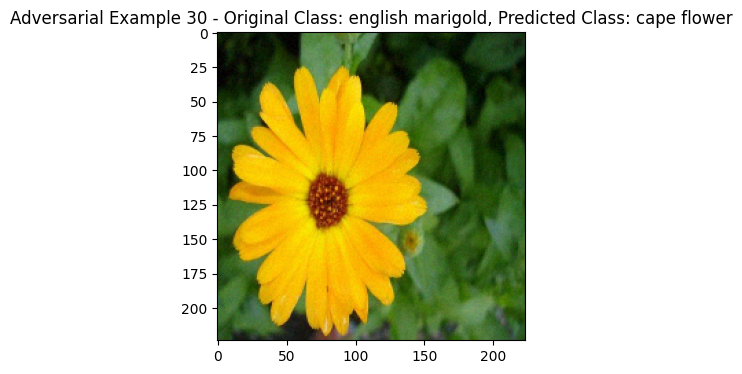

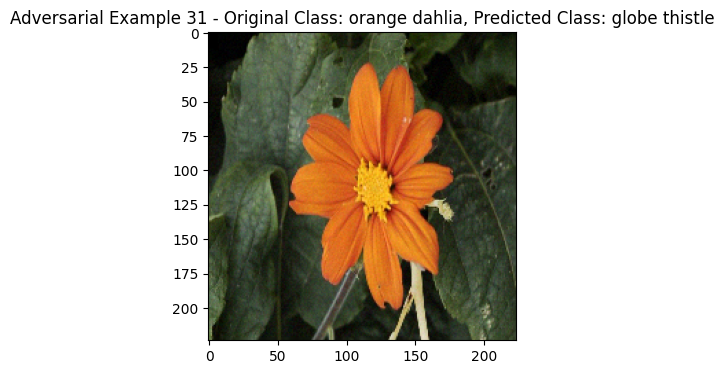

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Flatten, Dense, Reshape
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
dataset, info = tfds.load('oxford_flowers102', split='train', with_info=True, as_supervised=True)
num_classes = info.features['label'].num_classes
img_shape = (224, 224, 3)
def preprocess_image(image, label):
    image = tf.image.resize(image, (img_shape[0], img_shape[1]))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, num_classes)
    return image, label
dataset = dataset.map(preprocess_image)
num_samples = info.splits['train'].num_examples
num_train_samples = int(0.8 * num_samples)
num_val_samples = int(0.1 * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples
train_dataset = dataset.take(num_train_samples)
remaining_dataset = dataset.skip(num_train_samples)
val_dataset = remaining_dataset.take(num_val_samples)
test_dataset = remaining_dataset.skip(num_val_samples)
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
#GAN
def build_generator(latent_dim):
    model = Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(3, activation='tanh'))
    return model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator((224, 224, 3))
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch
art_classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=num_classes,
    input_shape=(224, 224, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
)
attack = FastGradientMethod(estimator=art_classifier, eps=0.02) #reducing this makes the hacks less obvious to the human eye
adversarial_test_images = attack.generate(test_images.numpy(), y=test_labels.numpy())
original_class_labels = np.argmax(test_labels, axis=1)
original_class_names = [class_names[i] for i in original_class_labels]
adversarial_test_probs = art_classifier.predict(adversarial_test_images)
adversarial_test_labels = np.argmax(adversarial_test_probs, axis=1)
adversarial_test_class_names = [class_names[i] for i in adversarial_test_labels]
adversarial_test_acc = np.sum(adversarial_test_labels == original_class_labels) / len(original_class_labels)
num_adversarial_images = adversarial_test_images.shape[0]
print(f"Number of Adversarial Images: {num_adversarial_images}")
print(f"Adversarial Test Accuracy: {adversarial_test_acc * 100:.2f}%")
num_display = min(num_adversarial_images, 35)
for i in range(num_display):
    plt.figure(figsize=(8, 4))
    plt.imshow(adversarial_test_images[i])
    plt.title(f'Adversarial Example {i + 1} - Original Class: {original_class_names[i]}, Predicted Class: {adversarial_test_class_names[i]}')
    plt.show()
#As I mentioned before, I wanted to attempt to Combine both GAN and the Library which really helped my project, here you can see that I have been able to successfully confuse the model, and able to generate the images with different classes.


In [9]:
pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00


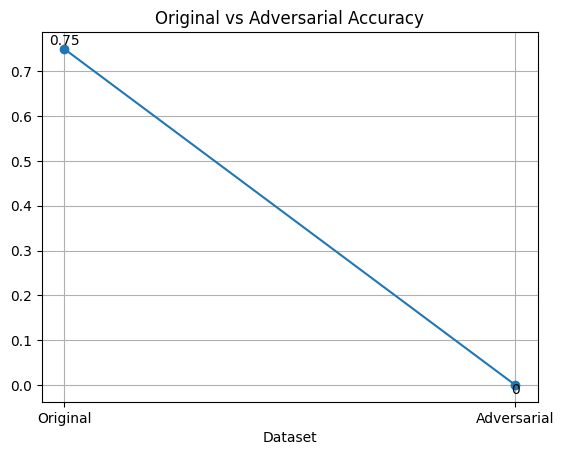

In [29]:
import matplotlib.pyplot as plt
original_accuracy = np.sum(original_predictions == np.argmax(test_labels, axis=1)) / len(test_labels)
adversarial_accuracy = np.sum(adversarial_predictions == np.argmax(test_labels, axis=1)) / len(test_labels)
plt.plot(['Original', 'Adversarial'], [original_accuracy, adversarial_accuracy], marker='o')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Original vs Adversarial Accuracy')
plt.grid(True)
plt.show()
